# 1. SBP EDA

In [57]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

## 1) data load & column 추출

In [58]:
# x변수로 sex, age, ht, wt, waist, smoking, alcohol / y는 sbp

df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [59]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','수축기혈압']]

df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','sbp']

## 2) 결측값 (null) 제거

In [60]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999089 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999089 non-null  int64  
 1   age      999089 non-null  int64  
 2   ht       999089 non-null  int64  
 3   wt       999089 non-null  int64  
 4   waist    999089 non-null  float64
 5   smoking  999089 non-null  float64
 6   alcohol  999089 non-null  object 
 7   sbp      999089 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


## 3) bmi(체질량지수), absi(체형지수) 추가

In [61]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)
df = df.round(decimals=2)


df['absi'] = (df['waist']*0.393701) /((df['bmi']**0.6666) * ((df['ht']/100)**0.5))
df = df.round(decimals = 2)

df.head()

,sex,age,ht,wt,waist,smoking,alcohol,sbp,bmi,absi
0,1,8,170,75,90.0,1.0,Y,120.0,25.95,3.10
1,1,7,180,80,89.0,3.0,N,130.0,24.69,3.08
2,1,9,165,75,91.0,1.0,N,120.0,27.55,3.06
3,1,11,175,80,91.0,1.0,N,145.0,26.12,3.08
4,1,11,165,60,80.0,1.0,N,138.0,22.04,3.12


## 4) float형 변환

In [62]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

In [63]:
df.head()

,sex,age,ht,wt,waist,smoking,alcohol,sbp,bmi,absi
0,1,8,170,75,90.0,1.0,1.0,120.0,25.95,3.10
1,1,7,180,80,89.0,3.0,0.0,130.0,24.69,3.08
2,1,9,165,75,91.0,1.0,0.0,120.0,27.55,3.06
3,1,11,175,80,91.0,1.0,0.0,145.0,26.12,3.08
4,1,11,165,60,80.0,1.0,0.0,138.0,22.04,3.12


## 5) 이상치 탐지 - 연속형 변수

### bmi

In [64]:
df.bmi.describe()

count    999089.000000
mean         23.914354
std           3.516931
min          12.490000
25%          21.480000
50%          23.880000
75%          25.950000
max          45.710000
Name: bmi, dtype: float64

lower :  8.070000000000004
upper :  39.36


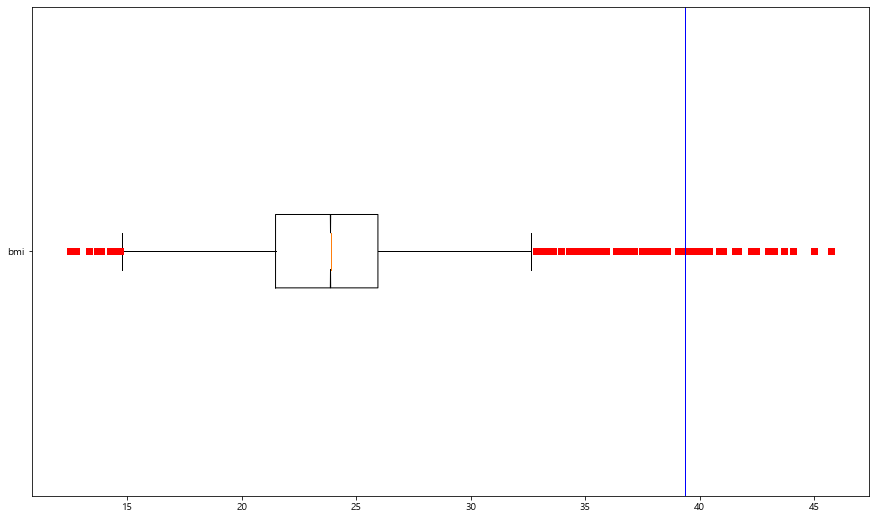

In [65]:
q25, q75 = np.quantile(df['bmi'], 0.25), np.quantile(df['bmi'], 0.75)
q50 = np.quantile(df['bmi'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['bmi'], 
            notch = 1, sym = 'rs', vert = 0)
plt.xticks(range(10, 50,5))
plt.yticks([1],['bmi'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.savefig('bmi_이상값.png')
plt.show()

### waist

In [66]:
df.waist.describe()

count    999089.000000
mean         81.231473
std          11.838789
min           8.000000
25%          74.100000
50%          81.000000
75%          87.800000
max         999.000000
Name: waist, dtype: float64

lower :  32.999999999999986
upper :  128.9


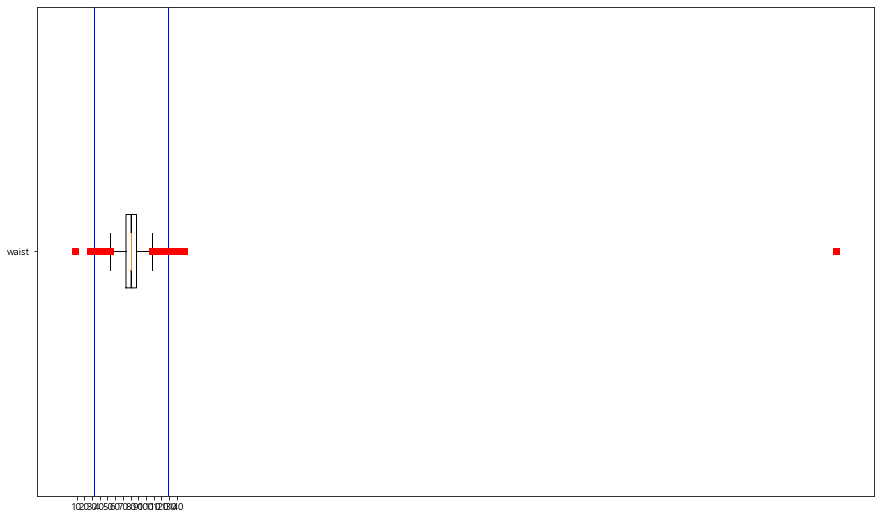

In [67]:
q25, q75 = np.quantile(df['waist'], 0.25), np.quantile(df['waist'], 0.75)
q50 = np.quantile(df['waist'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['waist'], 
            notch = 1, sym = 'rs', vert = 0)
plt.xticks(range(10,150,10))
plt.yticks([1],['waist'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.vlines(x = lower, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.savefig('waist_이상값.png')
plt.show()

### sbp

In [68]:
df.sbp.describe()

count    999089.000000
mean        122.431316
std          14.556632
min          58.000000
25%         112.000000
50%         120.000000
75%         131.000000
max         273.000000
Name: sbp, dtype: float64

lower :  55.0
upper :  188.0


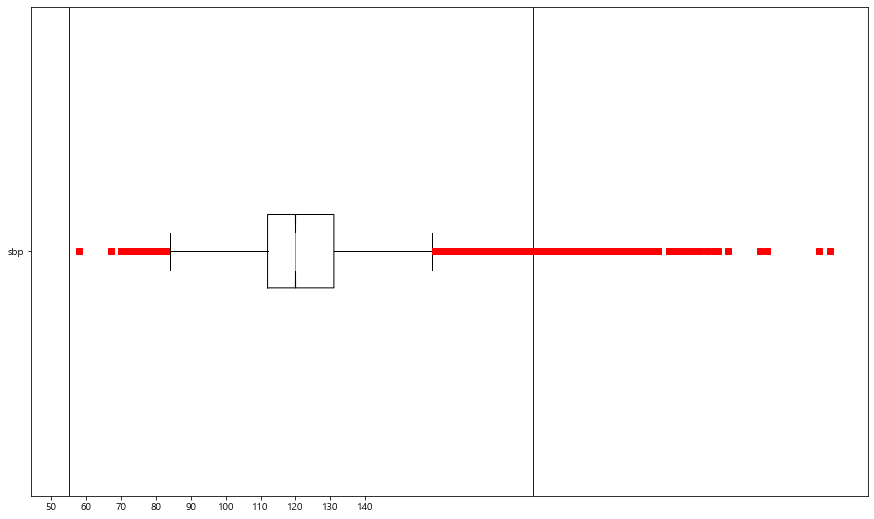

In [69]:
q25, q75 = np.quantile(df['sbp'], 0.25), np.quantile(df['sbp'], 0.75)
q50 = np.quantile(df['sbp'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['sbp'], 
            notch = 1, sym = 'rs', vert = 0)
plt.xticks(range(10,150,10))
plt.yticks([1],['sbp'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.vlines(x = lower, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.show()

In [96]:
df.loc[df['wt']<35]

,sex,age,ht,wt,waist,smoking,alcohol,sbp,bmi,absi
10904,2,16,135,30,72.0,1.0,0.0,110.0,16.46,3.77
19137,2,17,145,30,63.0,1.0,0.0,101.0,14.27,3.50
28876,2,16,140,30,66.0,1.0,0.0,128.0,15.31,3.56
53167,2,18,130,30,76.0,1.0,0.0,100.0,17.75,3.86
53509,2,17,135,30,71.0,1.0,0.0,136.0,16.46,3.72
...,...,...,...,...,...,...,...,...,...,...
936331,2,16,130,30,76.0,1.0,1.0,130.0,17.75,3.86
945927,2,18,140,30,66.0,1.0,0.0,110.0,15.31,3.56
970278,2,17,135,30,72.7,1.0,0.0,162.0,16.46,3.81
986880,2,16,135,30,61.5,1.0,0.0,106.0,16.46,3.22


### absi

In [71]:
df.absi.describe()

count    999089.000000
mean          3.034873
std           0.331347
min           0.360000
25%           2.900000
50%           3.030000
75%           3.160000
max          47.190000
Name: absi, dtype: float64

lower :  2.119999999999999
upper :  3.940000000000001


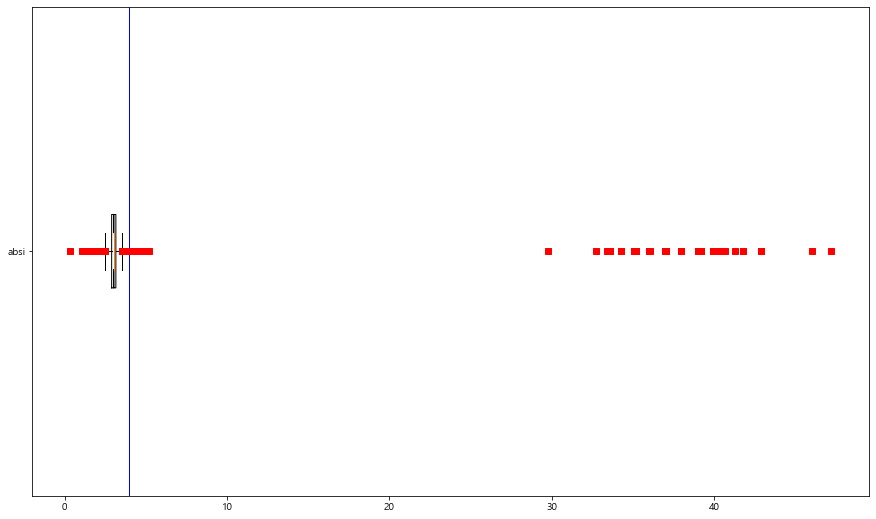

In [72]:
q25, q75 = np.quantile(df['absi'], 0.25), np.quantile(df['absi'], 0.75)
q50 = np.quantile(df['absi'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['absi'], 
            notch = 1, sym = 'rs', vert = 0)

plt.yticks([1],['absi'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.show()

## df : 이상치 제거 / df_o : 이상치 제거하지 않은 원본 df

In [73]:
df_o = df.copy()

# bmi
# df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index, inplace = True)

# waist
df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55)].index, inplace = True)

# absi
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)

# dbp
# df.drop(df.loc[(df['sbp']>188.0)|(df['sbp']<55.0)].index, inplace = True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998149 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998149 non-null  int64  
 1   age      998149 non-null  int64  
 2   ht       998149 non-null  int64  
 3   wt       998149 non-null  int64  
 4   waist    998149 non-null  float64
 5   smoking  998149 non-null  float64
 6   alcohol  998149 non-null  float64
 7   sbp      998149 non-null  float64
 8   bmi      998149 non-null  float64
 9   absi     998149 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


## 5) x변수 분포 

### 성별(SEX) - 혈압(SBP)

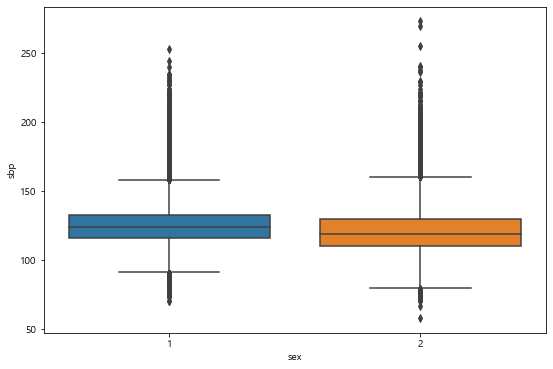

In [75]:
plt.figure(figsize = (9,6))
sns.boxplot(x = 'sex', y = 'sbp', data = df)
plt.savefig('sex_sbp.png')
plt.show()

### 나이(age) - 혈압(sbp)

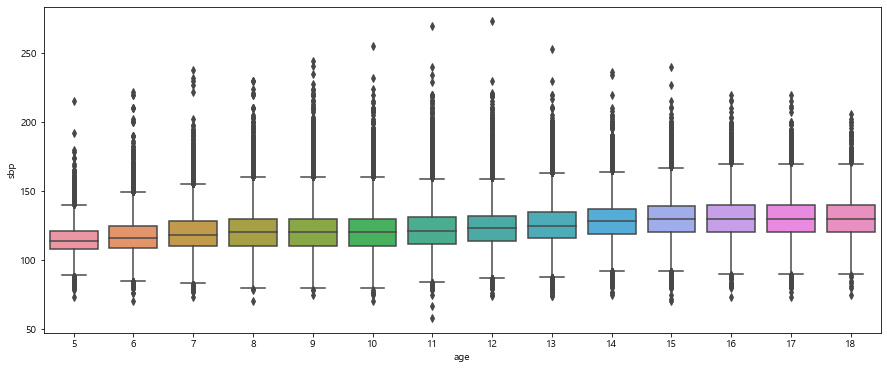

In [76]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'age', y = 'sbp', data = df)
plt.savefig('age_sbp.png')
plt.show()

### 키(ht) - 혈압(sbp)

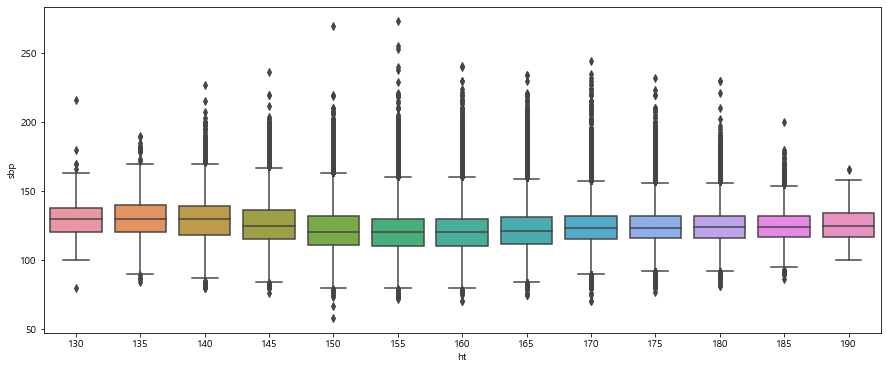

In [88]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'ht', y = 'sbp', data = df)
plt.savefig('ht_sbp.png')
plt.show()

### 체중(wt) - 혈압(sbp)

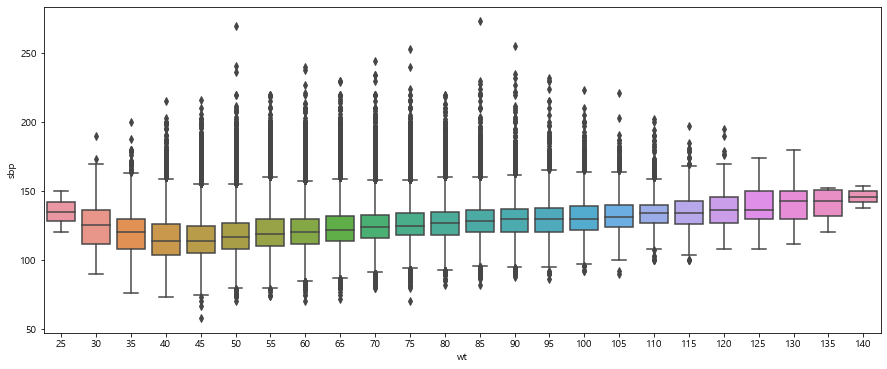

In [89]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'wt', y = 'sbp', data = df)
plt.savefig('wt_sbp.png')
plt.show()

### bmi - 혈압(sbp)

- 데이터가 너무 많아서 sampling(약 10%)해서 (랜덤) scatter함수로 표현

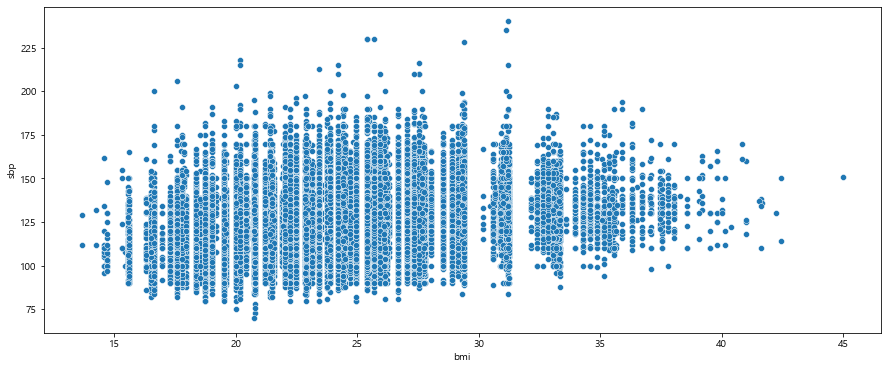

In [90]:
df_sample = df.sample(n=100000, random_state = 2045)

plt.figure(figsize = (15,6))
sns.scatterplot(df_sample.bmi, df_sample.sbp)
plt.savefig('bmi_sbp.png')
plt.show()

### 허리둘레(waist) - 혈압(sbp)

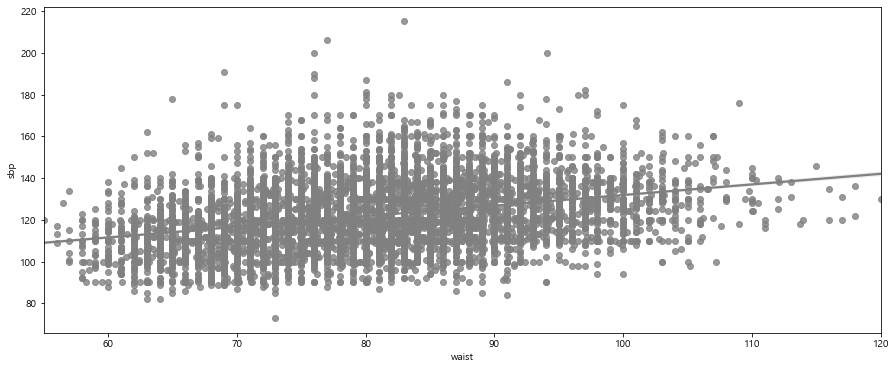

In [91]:
df_sample = df.sample(n=10000, random_state = 2045)

plt.figure(figsize = (15,6))
sns.regplot(df_sample.waist, df_sample.sbp, color = 'gray')
plt.savefig('waist_sbp.png')
plt.show()

### 체형지수(absi) - 혈압(sbp)

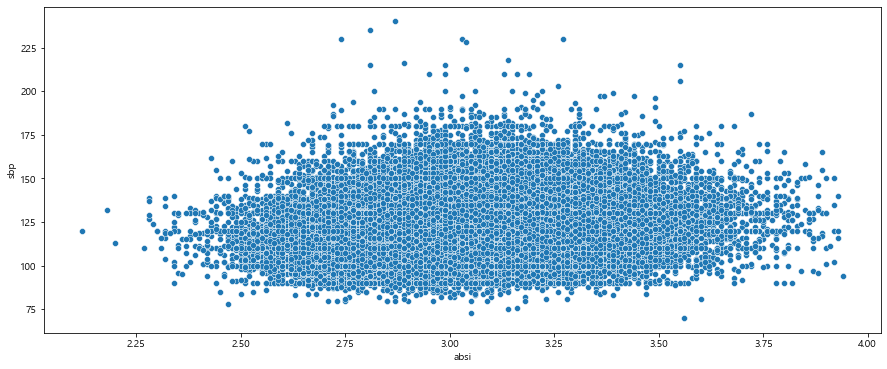

In [92]:
df_sample = df.sample(n=100000, random_state = 2045)


plt.figure(figsize = (15,6))
sns.scatterplot(df_sample.absi, df_sample.sbp)
plt.savefig('absi_sbp.png')
plt.show()

### 음주여부(alcohol) - 혈압(sbp)

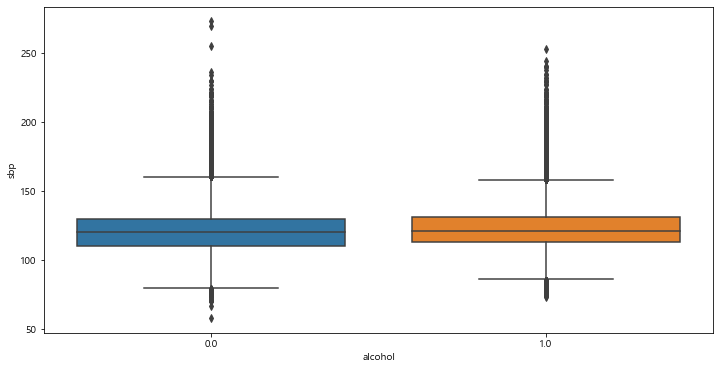

In [93]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'alcohol', y = 'sbp', data = df)
plt.savefig('alcohol_sbp.png')
plt.show()

### 흡연상태(smoking) - 혈압(sbp)

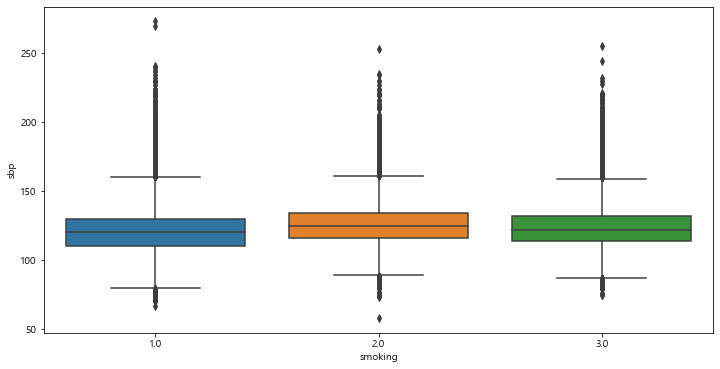

In [94]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'smoking', y = 'sbp', data = df)
plt.savefig('smoking_sbp.png')
plt.show()

### 혈압(sbp)

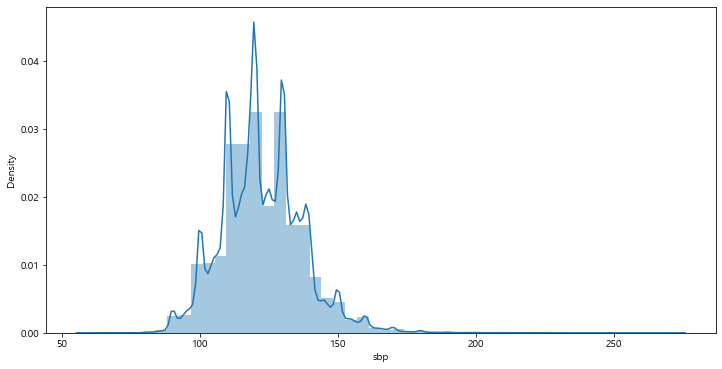

In [95]:
plt.figure(figsize = (12,6))
sns.distplot(df.sbp, hist = True, kde = True)
plt.savefig('sbp.png')
plt.show()

### x변수간 관계

<AxesSubplot:xlabel='bmi', ylabel='absi'>

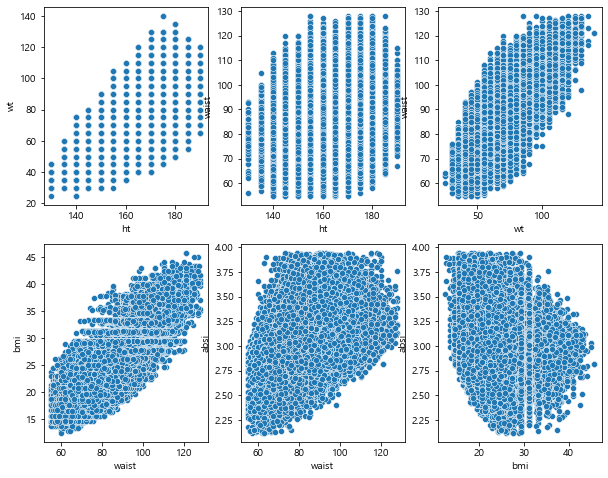

In [85]:
fig, axs = plt.subplots(figsize = (10,8), ncols = 3, nrows = 2 )

sns.scatterplot(x = 'ht', y = 'wt', data = df, ax = axs[0][0])
sns.scatterplot(x = 'ht', y = 'waist', data = df, ax = axs[0][1])
sns.scatterplot(x = 'wt', y = 'waist', data = df, ax = axs[0][2])
sns.scatterplot(x = 'waist', y = 'bmi', data = df, ax = axs[1][0])
sns.scatterplot(x = 'waist', y = 'absi', data = df, ax = axs[1][1])
sns.scatterplot(x = 'bmi', y = 'absi', data = df, ax = axs[1][2])

## * 변수scaling - 표준화(df_s)

In [86]:
scaler1 = StandardScaler()

x_bmi = scaler1.fit_transform(df[['bmi']])
x_waist = scaler1.fit_transform(df[['waist']])
x_absi = scaler1.fit_transform(df[['absi']])

df_s = df[['sex','age','ht','wt','smoking','alcohol','sbp']]

df_s['bmi'] = x_bmi
df_s['waist'] = x_waist
df_s['absi'] = x_absi

print(df_s.info())
df_s.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998149 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998149 non-null  int64  
 1   age      998149 non-null  int64  
 2   ht       998149 non-null  int64  
 3   wt       998149 non-null  int64  
 4   smoking  998149 non-null  float64
 5   alcohol  998149 non-null  float64
 6   sbp      998149 non-null  float64
 7   bmi      998149 non-null  float64
 8   waist    998149 non-null  float64
 9   absi     998149 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 116.0 MB
None


,sex,age,ht,wt,smoking,alcohol,sbp,bmi,waist,absi
0,1,8,170,75,1.0,1.0,120.0,0.578404,0.920798,0.339593
1,1,7,180,80,3.0,0.0,130.0,0.219742,0.816384,0.238949
2,1,9,165,75,1.0,0.0,120.0,1.033847,1.025212,0.138305
3,1,11,175,80,1.0,0.0,145.0,0.626795,1.025212,0.238949
4,1,11,165,60,1.0,0.0,138.0,-0.534585,-0.123341,0.440238


## * 변수scaling - 정규화(df_n)

In [87]:
scaler2 = MinMaxScaler()

x_bmi = scaler2.fit_transform(df[['bmi']])
x_waist = scaler2.fit_transform(df[['waist']])
x_absi = scaler2.fit_transform(df[['absi']])

df_n = df[['sex','age','smoking','ht','wt','alcohol', 'sbp']]

df_n['bmi'] = x_bmi
df_n['waist'] = x_waist
df_n['absi'] = x_absi

print(df_n.info())
df_n.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998149 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998149 non-null  int64  
 1   age      998149 non-null  int64  
 2   smoking  998149 non-null  float64
 3   ht       998149 non-null  int64  
 4   wt       998149 non-null  int64  
 5   alcohol  998149 non-null  float64
 6   sbp      998149 non-null  float64
 7   bmi      998149 non-null  float64
 8   waist    998149 non-null  float64
 9   absi     998149 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 116.0 MB
None


,sex,age,smoking,ht,wt,alcohol,sbp,bmi,waist,absi
0,1,8,1.0,170,75,1.0,120.0,0.405178,0.479452,0.538462
1,1,7,3.0,180,80,0.0,130.0,0.367249,0.465753,0.527473
2,1,9,1.0,165,75,0.0,120.0,0.453341,0.493151,0.516484
3,1,11,1.0,175,80,0.0,145.0,0.410295,0.493151,0.527473
4,1,11,1.0,165,60,0.0,138.0,0.287477,0.342466,0.549451
